In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import skfuzzy as fuzz

In [3]:
# Load the dataset
data = pd.read_csv("diabetes.csv")

In [4]:

# Display basic information about the dataset
print("Dataset information:")
print(data.info())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [5]:



# Display first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(data.head())

# Perform Exploratory Data Analysis (EDA)
print("\nExploratory Data Analysis:")
print(data.describe())


First few rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Exploratory Data Analysis:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369


Correlation matrix heatmap:


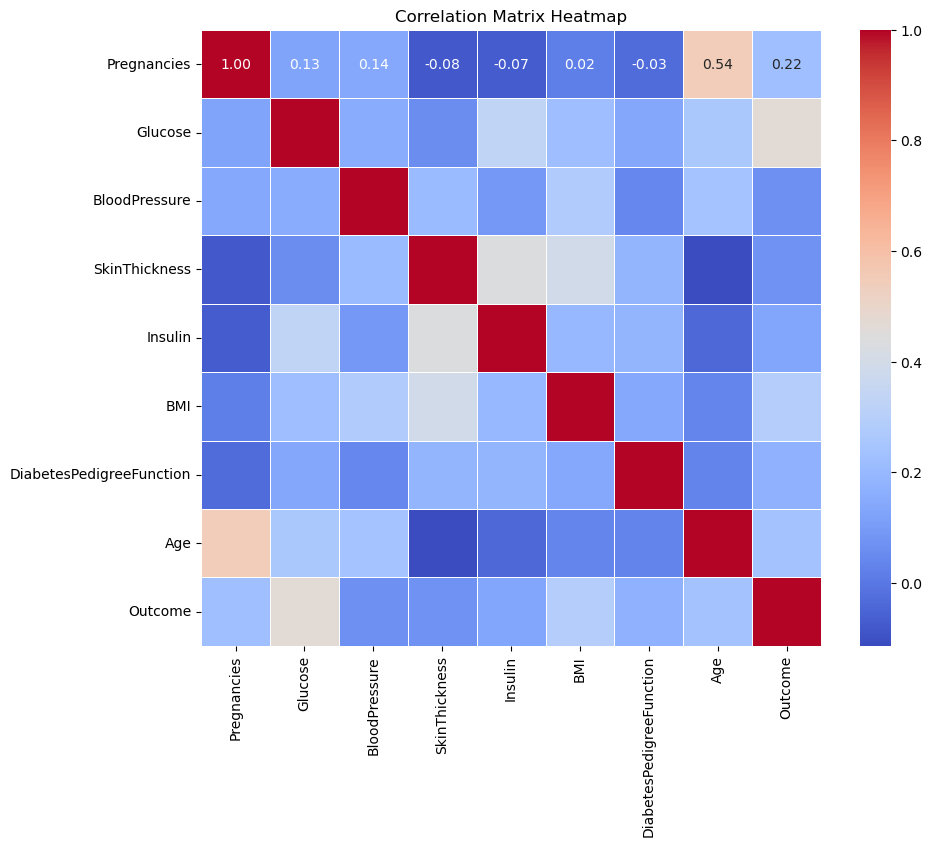

In [6]:
# Visualize the correlation matrix as a heatmap
print("\nCorrelation matrix heatmap:")
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:

# Separate features and target variable
X = data.drop('Outcome', axis=1)
y = data['Outcome']


In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Fuzzify the data
def fuzzify_data(data):
    fuzzy_data = []
    for col in data.columns:
        fuzzy_feature = fuzz.trimf(data[col].values, [data[col].min(), data[col].median(), data[col].max()])
        fuzzy_data.append(fuzzy_feature)
    return np.vstack(fuzzy_data).T

X_train_fuzzy = fuzzify_data(X_train)
X_test_fuzzy = fuzzify_data(X_test)

In [13]:
# Implement Crow Search Algorithm for hyperparameter tuning
def obj_function(params):
    rf_clf = RandomForestClassifier(n_estimators=params[0], max_depth=params[1], min_samples_split=params[2], min_samples_leaf=params[3], random_state=42)
    rf_clf.fit(X_train_fuzzy, y_train)
    return rf_clf.score(X_test_fuzzy, y_test)

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier


def sample_max_depth(min_depth, max_depth):
    """Samples a random integer from the specified range for max_depth."""
    return np.random.randint(min_depth, max_depth + 1)  # Inclusive of max_depth


def crow_search_algorithm(obj_function, lb, ub, population_size, max_iter):
    dim = len(lb)
    population = np.random.uniform(low=lb, high=ub, size=(population_size, dim))
    fitness = np.array([obj_function(ind) for ind in population])
    best_solution_idx = np.argmin(fitness)
    best_solution = population[best_solution_idx]

    for _ in range(max_iter):
        new_population = []
        for i in range(population_size):
            epsilon = np.random.uniform(-1, 1, size=dim)
            new_solution = population[i] + epsilon * (best_solution - population[i])
            new_solution = np.clip(new_solution, lb, ub)

            # Sample max_depth directly from the desired range
            new_solution[1] = sample_max_depth(lb[1], ub[1])

            new_fitness = obj_function(new_solution)
            if new_fitness < fitness[i]:
                population[i] = new_solution
                fitness[i] = new_fitness
            if new_fitness < fitness[best_solution_idx]:
                best_solution = new_solution
                best_solution_idx = i

    return best_solution, fitness[best_solution_idx]


def obj_function(params):
    rf_clf = RandomForestClassifier(n_estimators=int(params[0]), max_depth=int(params[1]), min_samples_split=int(params[2]), min_samples_leaf=int(params[3]), random_state=42)
    rf_clf.fit(X_train_fuzzy, y_train)
    return rf_clf.score(X_test_fuzzy, y_test)


# Assuming you have your X_train_fuzzy, X_test_fuzzy, y_train, and y_test defined earlier

best_params, best_accuracy = crow_search_algorithm(obj_function, lb=[50, 1, 2, 1], ub=[300, 20, 10, 4], population_size=10, max_iter=50)
print("Best parameters found by Crow Search Algorithm:", best_params)
print("Best accuracy found by Crow Search Algorithm:", best_accuracy)


Best parameters found by Crow Search Algorithm: [65.05445077 13.          4.48255102  1.35679434]
Best accuracy found by Crow Search Algorithm: 0.6038961038961039


In [15]:
# Use the best parameters found by CSA to train your model
best_model = RandomForestClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), min_samples_split=int(best_params[2]), min_samples_leaf=int(best_params[3]), random_state=42)
best_model.fit(X_train_fuzzy, y_train)
best_model_accuracy = best_model.score(X_test_fuzzy, y_test)
print("Accuracy of the best model:", best_model_accuracy)


Accuracy of the best model: 0.6038961038961039


In [16]:
# # Visualize the comparison of accuracy of the models
# models = ['Random Forest', 'Best Random Forest']
# accuracies = [rf_accuracy, best_model_accuracy]

# plt.figure(figsize=(8, 6))
# sns.barplot(x=models, y=accuracies)
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.show()
from sklearn.metrics import accuracy_score

# Calculate accuracy for the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_clf.predict(X_test_fuzzy))

# Visualize the comparison of accuracy of the models
models = ['Random Forest', 'Best Random Forest']
accuracies = [rf_accuracy, best_model_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


NameError: name 'rf_clf' is not defined